# BÀI THỰC HÀNH 2: MẠNG NEURAL TÍCH CHẬP

<b>Hướng dẫn nộp bài:</b> Các bạn commit và push code lên github, sử dụng file txt đặt tên theo cú pháp <MSSV>.txt chứa đường link dẫn đến github của bài thực hành và nộp file txt này tên courses..

Bộ dữ liệu sử dụng: [VinaFood21 dataset](https://arxiv.org/abs/2108.02929).

Link download: https://drive.google.com/file/d/1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR/view?usp=share_link.

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, utils, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization, Activation
)

print("TensorFlow version:", tf.__version__)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

2025-11-04 01:33:12.968243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762219993.193163      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762219993.248686      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


In [2]:
print("--- KIỂM TRA GPU ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Chỉ định TensorFlow chỉ sử dụng GPU đầu tiên nếu có nhiều cái
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Bật chế độ tăng trưởng bộ nhớ (memory growth) để tránh chiếm hết VRAM
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Đã phát hiện và thiết lập {len(gpus)} GPU:")
        print(gpus)
    except RuntimeError as e:
        # Lỗi xảy ra nếu thiết bị đã được khởi tạo
        print(e)
else:
    print("Không tìm thấy GPU. TensorFlow đang chạy trên CPU.")
print("--------------------")

--- KIỂM TRA GPU ---
Đã phát hiện và thiết lập 2 GPU:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
--------------------


# Bài 1: Xây dựng mô hình LeNet. Huấn luyện và đánh giá mô hình LeNet trên 4 độ đo precision, recall và F1-macro (sử dụng Adam làm optimizer).

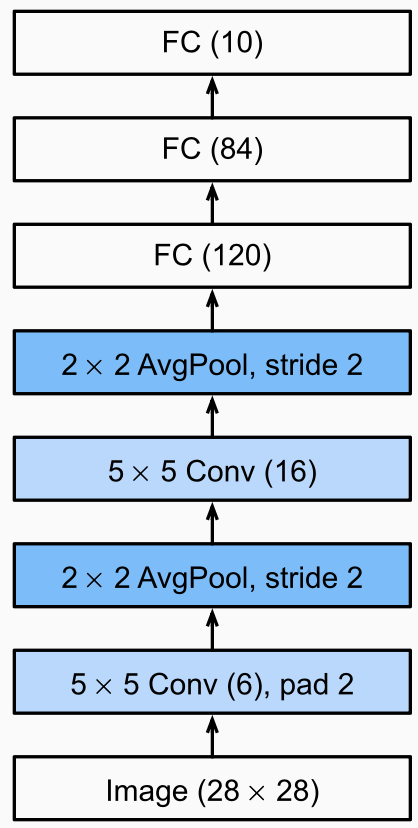

## 1.1 Chuẩn bị dữ liệu

In [3]:
# load data vô Ram
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


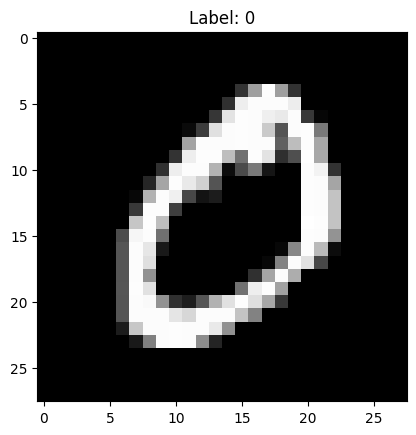

In [4]:
# Show a sample
plt.imshow(X_train[1], cmap='gray')
plt.title(f"Label: {y_train[1]}")
plt.show()

In [5]:
# Xem kích thước hai tập train, test
print(f"Kích thước tập train {X_train.shape}, kích thước tập test {X_test.shape}")
print(f"kích thước label y_train: {y_train.shape}, y_test: {y_test.shape}")

Kích thước tập train (60000, 28, 28), kích thước tập test (10000, 28, 28)
kích thước label y_train: (60000,), y_test: (10000,)


In [6]:
# Chuẩn hóa (normalize) và reshape
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [7]:
print(f"Initial dimention of X_train {X_train[1].shape}")

# Ta cần thêm 1 chanel ảo vô hình để input vô model là (28, 28, 1)
# Thêm chiều channel
X_train = np.expand_dims(X_train, axis=-1)  # (60000, 28, 28, 1)
X_test = np.expand_dims(X_test, axis=-1)    # (10000, 28, 28, 1)

print(f"X_train - After add a chanel {X_train[1].shape}")

Initial dimention of X_train (28, 28)
X_train - After add a chanel (28, 28, 1)


In [8]:
# Chuyển labels y_train và y_test sang one-hot
print(f"Initial dimention of y_train {y_train.shape}") # (60000, 1)

num_classes = 10
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

print(f"y_train - After onehot encode {y_train_cat.shape}") # (60000, 10)

Initial dimention of y_train (60000,)
y_train - After onehot encode (60000, 10)


In [9]:
# Chia validation data
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=0.1, random_state=42)

print(f"X_train mới có kích thước: {X_tr.shape} | X_test có kích thước {X_val.shape}")
print(f"y_tr mới có kích thước: {y_tr.shape} | y_val mới có kích thước {y_val.shape}")

X_train mới có kích thước: (54000, 28, 28, 1) | X_test có kích thước (6000, 28, 28, 1)
y_tr mới có kích thước: (54000, 10) | y_val mới có kích thước (6000, 10)


## 1.2 Định nghĩa mô hình

**Cấu trúc mạng LeNet-5 (chuẩn)**

| STT | Layer | Shape | Layer size | #Param |
|:---:|:----------------|:-------------|:-------------|:-----------:|
| 1 | **INPUT** | 32×32×1 | 1,024 | 0 |
| 2 | **CONV1** (f=5, s=1) | 28×28×6 | 4,704 | 156 |
| 3 | **POOL1** (f=2, s=2) | 14×14×6 | 1,176 | 0 |
| 4 | **CONV2** (f=5, s=1) | 10×10×16 | 1,600 | 2,416 |
| 5 | **POOL2** (f=2, s=2) | 5×5×16 | 400 | 0 |
| 6 | **FC1** | 120×1 | 120 | 48,120 |
| 7 | **FC2** | 84×1 | 84 | 10,164 |
| 8 | **Softmax (Output)** | 10×1 | 10 | 850 |

**Total parameters: 61,706**

In [10]:
lenet = Sequential([
    Input(shape=(28, 28, 1)), # Ảnh có 1 channel (grayscale)

    # Convolution 2D, 6 filter, kernel quét 5x5, Lenet cổ điển không thêm padding, nhưng ở đây ta sẽ thêm ở lớp đầu
    Conv2D(filters=6, kernel_size=(5,5), padding='same', strides=(1, 1), activation='relu'),

    # Pooling layer: Không học đặc trưng, tham số = 0, bước nhảy 2 ô (không có overlap giữa các pools)
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Conv2D: 16 bộ lọc, kernel trượt có size = 5x5, không padding, bước nhảy 1 
    Conv2D(filters=16, kernel_size=(5, 5), padding='valid', strides=(1,1), activation='relu'),

    # Pooling layer: 
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),

    Flatten(),
    # Fully connected: 
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax'),
])

I0000 00:00:1762220005.773684      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


In [11]:
lenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
lenet.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy', metrics=['accuracy']
)

In [13]:
print("--- Bắt đầu huấn luyện ---")
start_time = time.time()

history = lenet.fit(
    X_tr,
    y_tr,
    batch_size=128,
    epochs=10,
    validation_data=(X_val, y_val)
) # history lưu trữ thông tin quá trình huấn luyện

end_time = time.time()
print(f"--- Hoàn thành huấn luyện trong {end_time - start_time:.2f} giây ---")

--- Bắt đầu huấn luyện ---
Epoch 1/10


I0000 00:00:1762220009.713597      58 service.cc:148] XLA service 0x79bcac005030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762220009.714181      58 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762220010.015402      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


 61/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3529 - loss: 2.1538

I0000 00:00:1762220012.219653      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6855 - loss: 1.0816 - val_accuracy: 0.9327 - val_loss: 0.2340
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9351 - loss: 0.2102 - val_accuracy: 0.9593 - val_loss: 0.1347
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9613 - loss: 0.1292 - val_accuracy: 0.9748 - val_loss: 0.0934
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9719 - loss: 0.0913 - val_accuracy: 0.9803 - val_loss: 0.0709
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9781 - loss: 0.0725 - val_accuracy: 0.9823 - val_loss: 0.0627
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.0664 - val_accuracy: 0.9830 - val_loss: 0.0567
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9828 - loss: 0.0548 - val_accuracy: 0.9830 - val_loss: 0.0548
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9851 - loss: 0.0481 - val_accuracy: 0.9847 - val_

## 1.3 Đánh giá kết quả

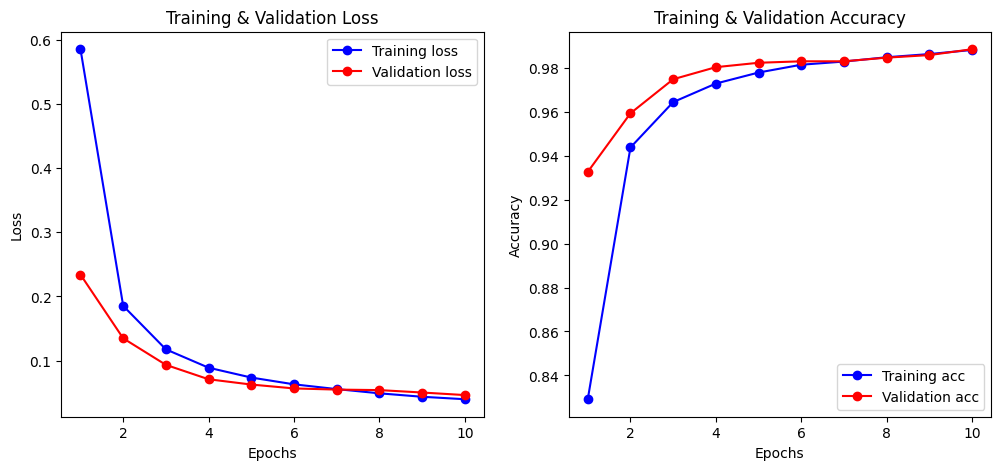

In [14]:
# Lấy dữ liệu từ history
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

> Mặc dù val loss có tăng nhẹ sau epoch 7, nhưng acc vẫn tăng. Điều này gợi ý ta có thể dừng ở epoch 6 hoặc tiếp tục training vì chưa có dấu hiệu overfitting

In [15]:
# Đánh giá trên tập test
test_loss, test_acc = lenet.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

Test accuracy: 0.9867, Test loss: 0.0454


In [16]:
# Kiểm tra tổng xác suất phải bằng 1 cho 2 dự đoán
sample_predict = lenet.predict(np.expand_dims(X_test[1], axis=0))
print(f"sample_predict shape: {sample_predict.shape} | sample_predict vector: {sample_predict}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
sample_predict shape: (1, 10) | sample_predict vector: [[9.4962570e-07 1.2673014e-04 9.9987125e-01 6.2127236e-07 4.1335406e-09
  1.0036786e-09 2.2866333e-08 1.6691182e-08 4.4332381e-07 9.3165073e-11]]


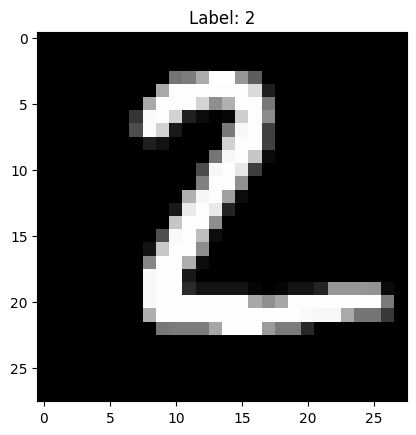

In [17]:
plt.imshow(X_test[1], cmap='gray')
plt.title(f"Label: {y_test[1]}")
plt.show()

In [18]:
# Lấy dự đoán trên tập test
y_pred_prob = lenet.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1) # Chuyển từ xác suất (softmax) về nhãn (0-9)

print("\n--- ĐÁNH GIÁ TỔNG THỂ (MACRO AVG) ---")

# Tính toán các độ đo tổng thể
acc = accuracy_score(y_test, y_pred)
pre_macro = precision_score(y_test, y_pred, average='macro')
rec_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro') # Đây là F1-macro bạn yêu cầu

print(f"Overall Accuracy: {acc:.4f}")
print(f"Macro Precision:  {pre_macro:.4f}")
print(f"Macro Recall:     {rec_macro:.4f}")
print(f"Macro F1-Score:   {f1_macro:.4f}")

print("\n--- ĐÁNH GIÁ CHI TIẾT TỪNG CHỮ SỐ (0-9) ---")

# Sử dụng classification_report để in chi tiết precision, recall, f1-score cho từng lớp
# 'support' là số lượng mẫu thực tế của từng lớp trong tập test
print(classification_report(y_test, y_pred, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- ĐÁNH GIÁ TỔNG THỂ (MACRO AVG) ---
Overall Accuracy: 0.9867
Macro Precision:  0.9869
Macro Recall:     0.9865
Macro F1-Score:   0.9866

--- ĐÁNH GIÁ CHI TIẾT TỪNG CHỮ SỐ (0-9) ---
              precision    recall  f1-score   support

           0     0.9770    0.9949    0.9858       980
           1     0.9835    0.9991    0.9913      1135
           2     0.9874    0.9893    0.9884      1032
           3     0.9833    0.9891    0.9862      1010
           4     0.9858    0.9929    0.9893       982
           5     0.9899    0.9843    0.9871       892
           6     0.9968    0.9791    0.9879       958
           7     0.9844    0.9844    0.9844      1028
           8     0.9968    0.9713    0.9839       974
           9     0.9841    0.9802    0.9821      1009

    accuracy                         0.9867     10000
   macro avg     0.9869    0.9865    0.9866     10000
weighted avg     0.9868    0.9867    0.9867     10000

